In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils01 import GROParser

In [2]:
gro = "input/solv_ions_prot.gro"
CUTOFF_RADIUS = 1.0

groparser = GROParser(gro, CUTOFF_RADIUS)
MAINCHAIN = groparser.mainchains
N_ATOMS = groparser.n_atoms
EACH_N_ATOMS = groparser.each_n_atoms
SLICE_INDECES = groparser.slice_indeces
ARRANGED_INDECES = groparser.arranged_indeces
ADJACENT_INDECES = groparser.adjacent_indeces
AB_INDECES = groparser.ab_indeces
ATOM_ALIGN = groparser.atom_align

# read trj

In [3]:
filepath = "input/xvg/2fs/MainChain-coord.xvg"
# filepath = "input/run1/MainChain-coord.xvg"
acttrj = pd.read_csv(filepath, comment='@', delimiter='\t',
                            header=None, skiprows=14).values[:, 1:]
acttrj = acttrj.reshape(acttrj.shape[0], -1, 3)
acttrj = acttrj[:, ARRANGED_INDECES, :]
acttrj.shape

(101, 1235, 3)

In [4]:
# filepath = "workspace/04-simulate/test25.npy"
# prdtrj = np.load(filepath)
# prdtrj = prdtrj[:, ARRANGED_INDECES, :]
# prdtrj.shape

# RDF

In [5]:
def cal_rdf(trj, species, residues, cutoff=1.0, n_bins=100):
    all_distances = []
    for residue in residues:
        i, j = SLICE_INDECES[species[0]]
        center_coords = trj[:, i:j, :]
        center_coords = center_coords[:, residue, :]

        i, j = SLICE_INDECES[species[1]]
        nearby_coords = trj[:, i:j, :]
        
        center_coords = np.tile(center_coords, nearby_coords.shape[1]).reshape(center_coords.shape[0], -1, 3)

        distances = np.sqrt(np.sum(np.square(np.subtract(nearby_coords, center_coords)), axis=2)).flatten()
        distances = distances[distances<=cutoff]
        all_distances.extend(distances.tolist())
    
    hist, bins = np.histogram(all_distances, bins=n_bins)
    dr = bins[1] - bins[0]
    rho = 1
    rdf = hist/(4*np.pi*np.power(bins[:-1],2)*dr*rho)
    return bins[:-1], rdf

In [6]:
species_list = [
    ['CA', 'N'],
    ['CA', 'C'],
    ['N', 'C'],
    ['C', 'O'],
    ['CA', 'O'],
    ['N', 'O'],
]

In [7]:
def plot_rdf(trj):
    fig = plt.figure(figsize=(10,4*len(species_list)))

    for i, species in enumerate(species_list):
        residues = range(EACH_N_ATOMS[species[0]])
        radiuses, rdf = cal_rdf(trj, species, residues)

        fig.add_subplot(len(species_list), 1, i+1)

        plt.plot(radiuses, rdf)
        plt.scatter(radiuses, rdf)

        plt.title(f"{species[0]}-{species[1]} (peak: {radiuses[np.argmax(rdf)]:.2f})")

In [8]:
def plot_each_peak(trj):
    fig = plt.figure(figsize=(10,4*len(species_list)))

    for i, species in enumerate(species_list):
        residues = range(EACH_N_ATOMS[species[0]])
        
        radiuses_rdfs = [cal_rdf(trj[[t], :, :], species, residues) for t in range(trj.shape[0])]
        peaks = [radiuses[np.argmax(rdf)] for radiuses, rdf in radiuses_rdfs]

        fig.add_subplot(len(species_list), 1, i+1)

        plt.plot(list(range(trj.shape[0])), peaks)
        plt.scatter(list(range(trj.shape[0])), peaks)

        plt.title(f"{species[0]}-{species[1]}")

## actual

### whole time

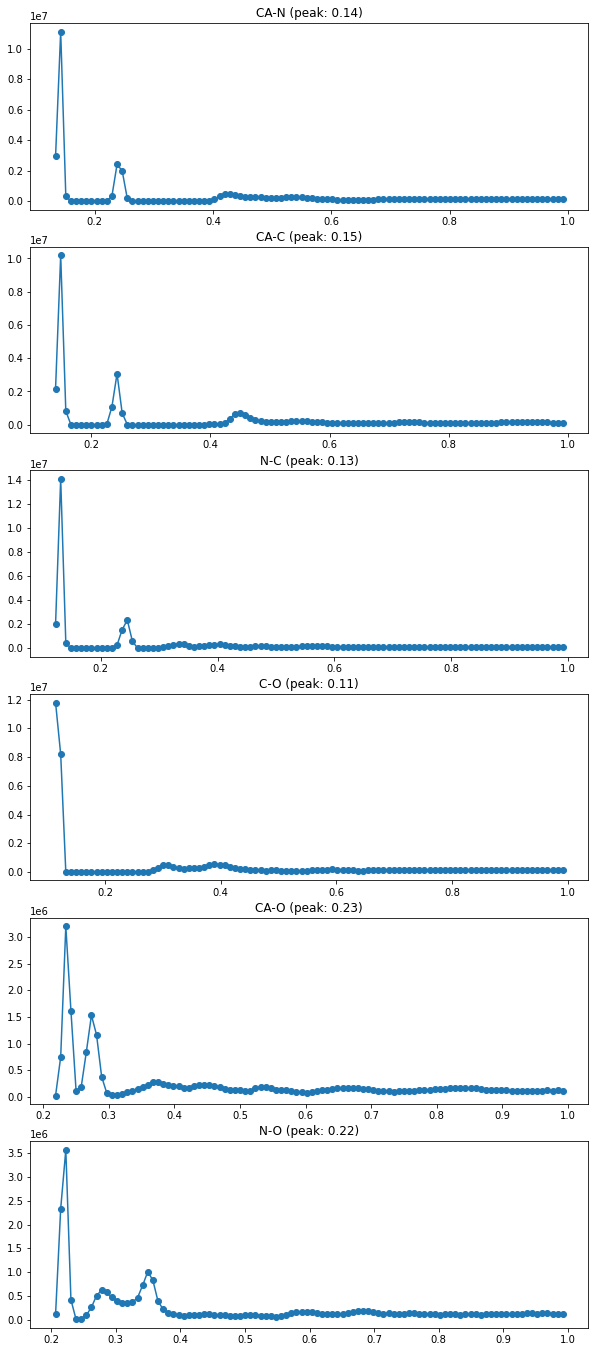

In [9]:
plot_rdf(acttrj)

### peak each time

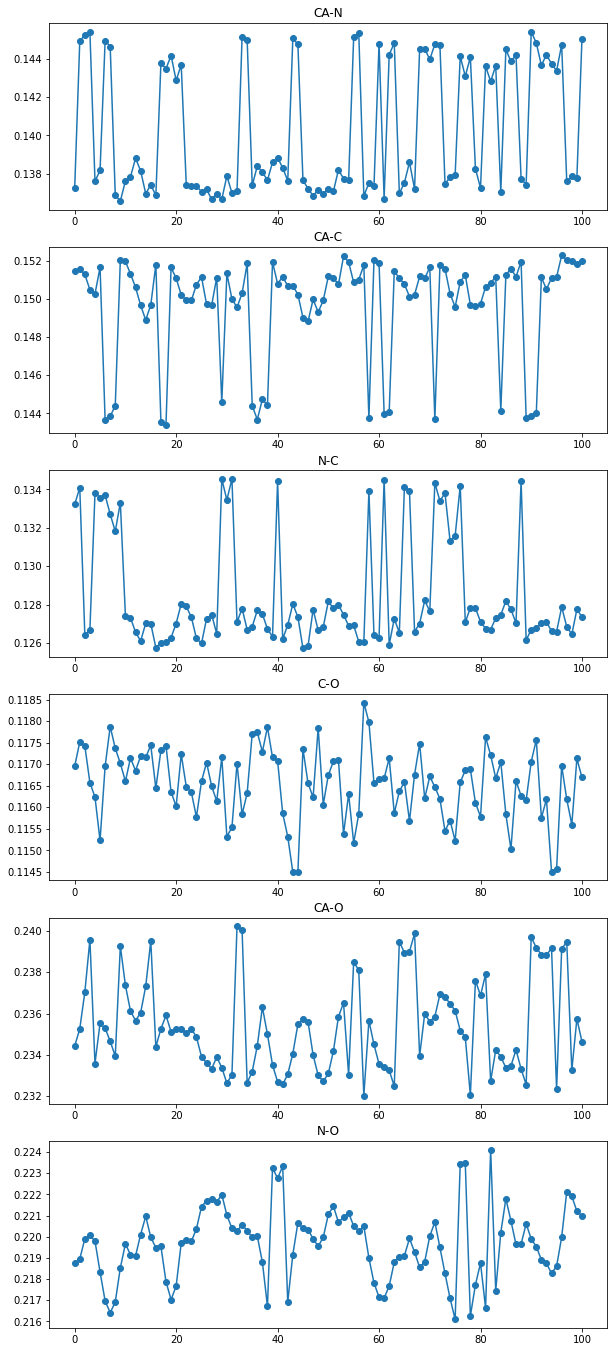

In [10]:
plot_each_peak(acttrj)

# ADF

In [11]:
def cal_degrees(coords_center, coords2, coords3):
    us = np.subtract(coords2, coords_center)
    vs = np.subtract(coords3, coords_center)
    
    inns = np.inner(us, vs)[0]
    norms = np.sqrt(np.sum(np.square(us), axis=1)) * np.sqrt(np.sum(np.square(vs), axis=1))

    cos_thetas = inns / norms
    degs = np.rad2deg(np.arccos(np.clip(cos_thetas, -1.0, 1.0)))
    return degs

In [12]:
approved_species_sets = {
    'CA': [set(['N', 'C'])],
    'N': [set(['CA', 'C'])],
    'C': [set(['CA', 'N']), set(['CA', 'O']), set(['N', 'O'])]
}

def cal_degree_list(trj, center_species, species_set):
    if species_set not in approved_species_sets[center_species]:
        print('unapproved species sets')
    
    

    l, u = SLICE_INDECES[center_species]

    degree_list = []
    for i in range(l, u):
        coords_center = trj[:, i, :]
        
        try:
            if center_species == 'C' and species_set == set(['CA', 'N']):
                coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
            elif center_species == 'C' and species_set == set(['O', 'N']):
                coords2 = trj[:, ADJACENT_INDECES[i][1][0], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
            else:
                coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][0], :]
        except IndexError:
            continue

        degree_list.extend(cal_degrees(coords_center, coords2, coords3).flatten().tolist())
        
    return degree_list

In [13]:
N_BINS = 20
N_FIGS = sum([len(li) for li in approved_species_sets.values()])

In [14]:
def plot_adf(trj):
    fig = plt.figure(figsize=(20,5*N_FIGS))

    i = 0
    for species, spset_list in approved_species_sets.items():
        for spset in spset_list:
            i += 1
            fig.add_subplot(N_FIGS, 1, i)

            degree_list = cal_degree_list(trj, species, spset)
            hist, bins = np.histogram(degree_list, bins=N_BINS)

            plt.bar([f"{int(round(bins[i]))}-{int(round(bins[i+1]))}" for i in range(len(hist))], hist)

            sp1, sp2 = spset
            plt.title(f"{sp1}-{species}-{sp2} (mean: {int(round(np.mean(degree_list)))})")

In [15]:
# def plot_each_adf_mean(trj):
#     fig = plt.figure(figsize=(20,3*N_FIGS))

#     i = 0
#     for species, spset_list in approved_species_sets.items():
#         for spset in spset_list:
#             i += 1
#             fig.add_subplot(N_FIGS, 1, i)

#             degree_list = cal_degree_list(trj, species, spset)
#             hist, bins = np.histogram(degree_list, bins=N_BINS)

#             degree_list_each_time = [cal_degree_list(trj[[t], :, :], species, spset) for t in range(trj.shape[0])]
#             mean_angle_each_time = [np.mean(degree_list) for degree_list in degree_list_each_time]

#             plt.plot(list(range(trj.shape[0])), mean_angle_each_time)
#             plt.scatter(list(range(trj.shape[0])), mean_angle_each_time)

#             sp1, sp2 = spset
#             plt.title(f"{sp1}-{species}-{sp2}")

In [16]:
def plot_each_adf_mean(trj):
    fig = plt.figure(figsize=(20,5))
    fig.add_subplot(1, 1, 1)

    i = 0
    for species, spset_list in approved_species_sets.items():
        for spset in spset_list:
            i += 1

            degree_list = cal_degree_list(trj, species, spset)
            hist, bins = np.histogram(degree_list, bins=N_BINS)

            degree_list_each_time = [cal_degree_list(trj[[t], :, :], species, spset) for t in range(trj.shape[0])]
            mean_angle_each_time = [np.mean(degree_list) for degree_list in degree_list_each_time]

            sp1, sp2 = spset
            plt.plot(list(range(trj.shape[0])), mean_angle_each_time, label=f"{sp1}-{species}-{sp2}")
            
    plt.legend()

## actual

### whole time

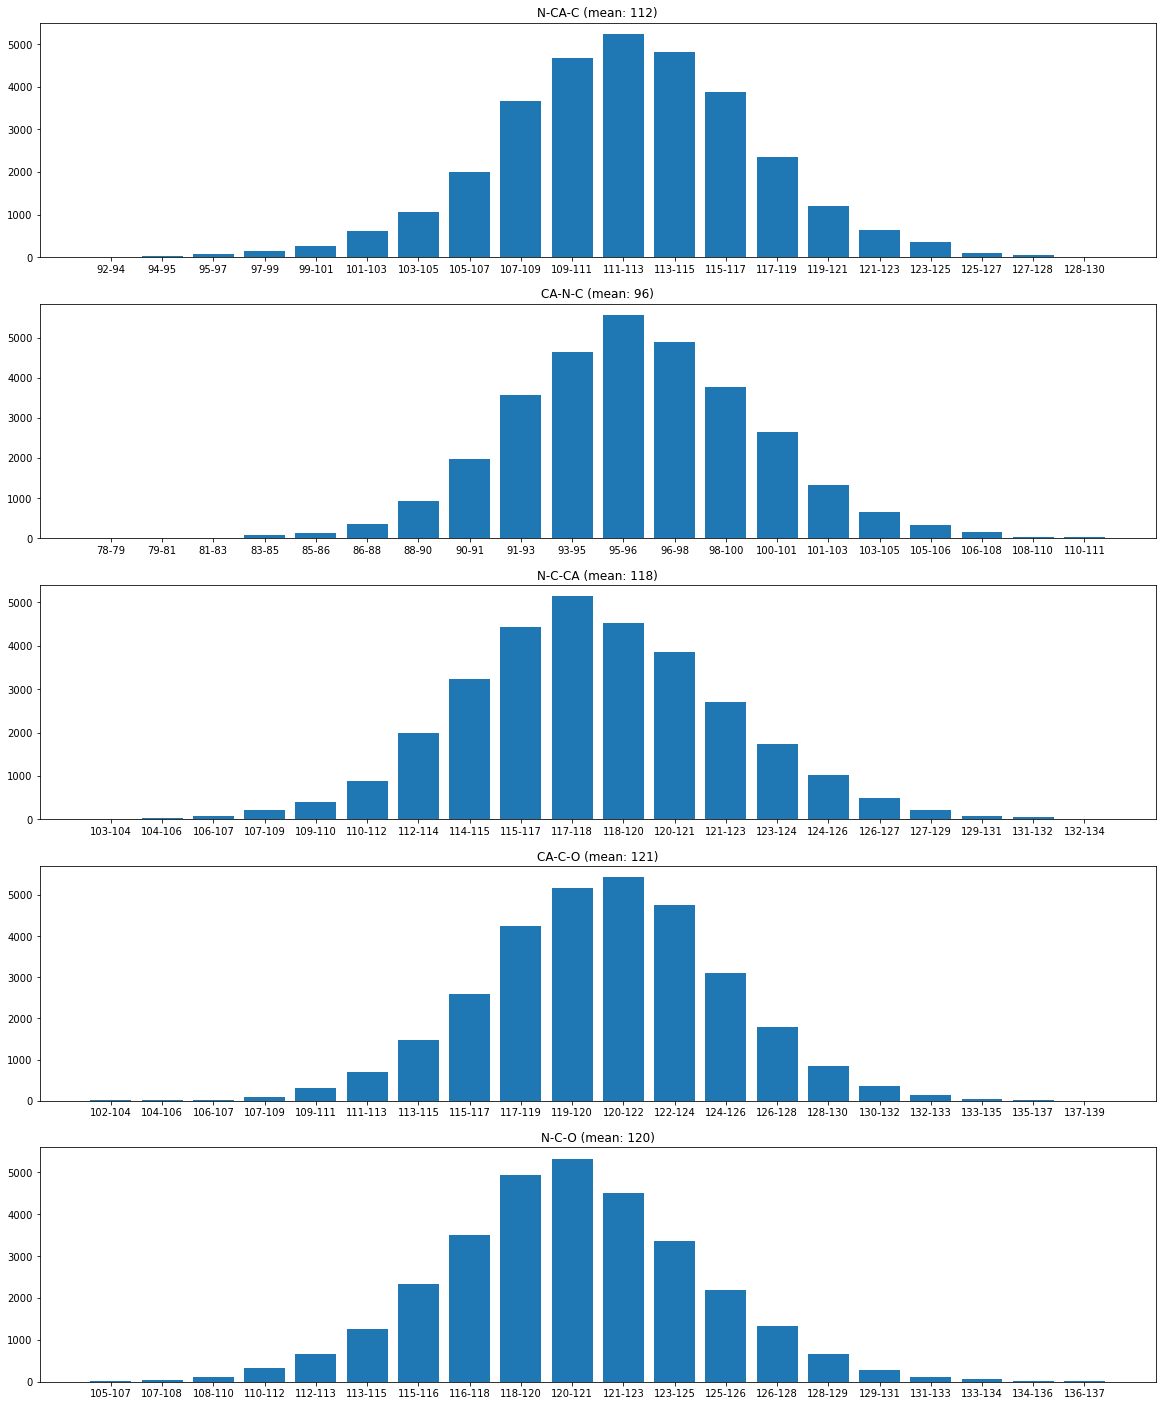

In [17]:
plot_adf(acttrj)

### mean each time

In [ ]:
plot_each_adf_mean(acttrj)